In [1]:
import sys
sys.path.append('..')
import time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from utils.oanda_utils import get_candles_df, load_candles_df
from utils.indicators import add_sma
from utils.preprocesses import split_df, add_target

In [4]:
from utils.stats import jarque_bera_normal_dist, ljung_box_auto_corr, adfuller_unit_root

In [5]:
import datetime

In [108]:
df = load_candles_df("../data/usd_jpy_m1.csv")
df['time']  = pd.to_datetime(df['time'], utc=True)
df = df.set_index('time')

In [109]:
target_window = 10
df['target'] = df['C'].apply(np.log).diff().shift(-1)

df = df.dropna()

In [110]:
lag_window = 30
features = ["O", "H", "L", "C"]
# features = ["C"]

X = np.zeros([df.shape[0] - lag_window - target_window, lag_window, len(features)])
y = np.zeros([df.shape[0] - lag_window - target_window, 1])

for i in range(len(df))[lag_window:-target_window]:
    X[i-lag_window-target_window, :, :] = df[features].iloc[i-lag_window:i]
    y[i-lag_window-target_window, 0] = df['target'].iloc[i]

In [111]:
from sklearn.preprocessing import StandardScaler as ss

In [112]:
scaler = ss()

In [113]:
mean = X.mean()
std = X.std()

In [114]:
X = (X - mean) / std

In [115]:
idx = df.index[lag_window:-target_window]

In [116]:
train_start = datetime.datetime(2021, 3, 23, tzinfo=datetime.timezone.utc)
valid_start = datetime.datetime(2021, 3, 25, tzinfo=datetime.timezone.utc)
test_start = datetime.datetime(2021, 3, 26, tzinfo=datetime.timezone.utc)
test_end = datetime.datetime(2021, 3, 27, tzinfo=datetime.timezone.utc)

In [117]:
cond_train = idx >= train_start
cond_train &= idx < valid_start

cond_valid = idx >= valid_start
cond_valid &= idx < test_start

cond_test = idx >= test_start
cond_test &= idx < test_end


X_train = X[cond_train]
y_train = y[cond_train]

X_valid = X[cond_valid]
y_valid = y[cond_valid]

X_test = X[cond_test]
y_test = y[cond_test]

In [118]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [119]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [120]:
def build_model(inputs, outputs, neurons, activ_func="tanh",
                dropout=0.25, loss="mae", optimizer="adam"):
    
    model = Sequential()
    
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=outputs.shape[1]))
    model.add(Activation(activ_func))
    
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [121]:
np.random.seed(999)
 
# 初期モデルの構築
model = build_model(X_train, y_train, neurons=20)

In [122]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 20)                2000      
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 21        
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total params: 2,021
Trainable params: 2,021
Non-trainable params: 0
_________________________________________________________________


In [123]:
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    validation_data=(X_valid, y_valid),
                    batch_size=20, verbose=1,
                    shuffle=True)


Epoch 1/100
140/140 [==============================] - 2s 6ms/step - loss: 0.1640 - val_loss: 0.0077
Epoch 2/100
140/140 [==============================] - 1s 6ms/step - loss: 0.0183 - val_loss: 0.0025
Epoch 3/100
140/140 [==============================] - 1s 6ms/step - loss: 0.0061 - val_loss: 0.0024
Epoch 4/100
140/140 [==============================] - 1s 7ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 5/100
140/140 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 6/100
140/140 [==============================] - 1s 7ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 7/100
140/140 [==============================] - 1s 8ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 8/100
140/140 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 9/100
140/140 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 10/100
140/140 [==============================] - 1s 7ms/step - loss: 0.0015 - val_lo

140/140 [==============================] - 1s 5ms/step - loss: 9.3694e-05 - val_loss: 1.0313e-04
Epoch 78/100
140/140 [==============================] - 1s 7ms/step - loss: 1.0859e-04 - val_loss: 1.0693e-04
Epoch 79/100
140/140 [==============================] - 1s 5ms/step - loss: 1.0555e-04 - val_loss: 1.2661e-04
Epoch 80/100
140/140 [==============================] - 1s 7ms/step - loss: 1.3251e-04 - val_loss: 1.6021e-04
Epoch 81/100
140/140 [==============================] - 1s 7ms/step - loss: 7.5265e-05 - val_loss: 1.7041e-04
Epoch 82/100
140/140 [==============================] - 1s 10ms/step - loss: 1.1556e-04 - val_loss: 1.2768e-04
Epoch 83/100
140/140 [==============================] - 1s 8ms/step - loss: 7.9435e-05 - val_loss: 7.8162e-05
Epoch 84/100
140/140 [==============================] - 1s 7ms/step - loss: 9.1543e-05 - val_loss: 7.2259e-05
Epoch 85/100
140/140 [==============================] - 1s 8ms/step - loss: 7.4508e-05 - val_loss: 4.2927e-04
Epoch 86/100
140/140 [

<AxesSubplot:>

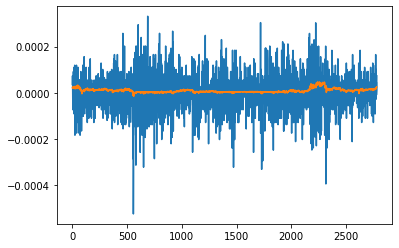

In [124]:
pd.Series(y_train[:,0]).plot()
pd.Series(model.predict(X_train)[:,0]).plot()

<AxesSubplot:>

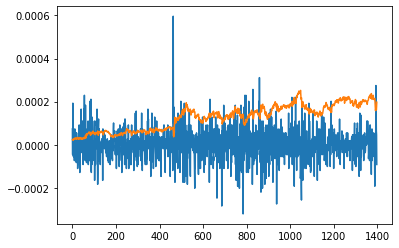

In [125]:
pd.Series(y_valid[:,0]).plot()
pd.Series(model.predict(X_valid)[:,0]).plot()

<AxesSubplot:>

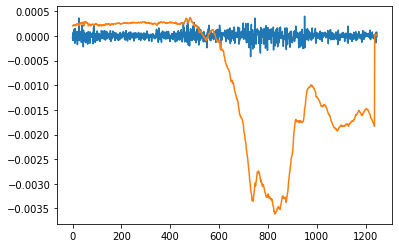

In [126]:
pd.Series(y_test[:,0]).plot()
pd.Series(model.predict(X_test)[:,0]).plot()